# Visual QC notebook

This notebook is designed to create outputs used in a visual QC check of computed indicators. Output files are counted, and 20% of the files are randomly selected for QC.

#### How to use with `prefect` via `papermill`: 

This notebook should be run as the final step of the `prefect` indicator flow. The output will be saved as a new notebook in the QC directory created during the flow. To accomplish this, create a task in the `prefect` flow that will execute this notebook from the command line using `papermill`, e.g.:

```papermill path/to/repo/indicators/visual_qc.ipynb path/to/qc/output/output.ipynb -r indicators "rx1day" -r models "GFDL-ESM4 CESM2 TaiESM1" -r "historical ssp126 ssp245 ssp370 ssp585"```


 The first argument is this notebook's location, which can be constructed using the `{working_directory}` parameter of the flow run (ie, the notebook's location within the downloaded repo directory). The second argument is the desired notebook output location, which can also be constructed using the `{working_directory}` parameter of the flow run. The remaining arguments for indicators, models, and scenarios should be taken directly from the flow run's `{indicators}`, `{models}`, and `{scenarios}` parameters. Note that each parameter is preceded by the `-r` tag to designate a raw string, and the multiple items are enclosed in quotes and separated by a single white space.






In [259]:
# this cell is tagged "parameters" and contains default parameter values for this notebook
# parameters injected by papermill from the command line will be written into a new cell directly beneath this one, and will override the values in this cell
# like on the command line, use a raw string surrounded by quotes with values separated by a single blank space

#dirs
working_directory = "/import/beegfs/CMIP6/snapdata/"
input_dir = "/import/beegfs/CMIP6/arctic-cmip6/regrid/"

#lists
indicators = "rx1day"
models = "GFDL-ESM4 CESM2 TaiESM1"
scenarios = "historical ssp126 ssp245 ssp370 ssp585"


Import packages.

In [260]:
from pathlib import Path
import random
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from indicators import *
from luts import idx_varid_lu, varid_freqs

#### Setup
Define data sources and parameters for QC.

In [261]:
import warnings
warnings.filterwarnings("ignore")

#convert dirs to Path objects
input_dir = Path(input_dir)
output_dir = Path(working_directory).joinpath("output/")

#split raw strings and convert to lists
#TODO delete if not used!
indicators, models, scenarios = indicators.split(" "), models.split(" "), scenarios.split(" ")

#list all netCDF files in the output directory
output_files = [f for f in output_dir.glob("**/*.nc")]

#randomly pick 20% of the output files for visual QC
qc_files = random.sample(output_files, round(len(output_files) * .2))

#lat/lon slices and titles for these regions
lat_slices = [slice(45, 65), slice(55, 75), slice(60, 80)]
lon_slices = [slice(90, 120), slice(180, 210), slice(310, 340)]
region_titles = ["Lake Baikal", "Seward Peninsula", "Greenland"]

Create a function that will deconstruct the file path of a computed indicator, and use its parts to locate the source files used to compute that indicator. The indicator is recomputed, all years are merged, and output is an `xarray.Dataset` that should be an exact match of the original indicator file. **Note that this will grab all regridded source files for each variable!**

In [262]:
def find_inputs_and_recompute_indicator(fp, input_dir):
    source_files={}
    indicator, model, scenario = fp.parts[-1].split("_")[0], fp.parts[-1].split("_")[1], fp.parts[-1].split("_")[2]
    vars = idx_varid_lu[indicator]
    for var in vars:
        frequency = varid_freqs[var][0]
        source_files[var]=[f for f in input_dir.joinpath(model, scenario, frequency, var).glob("**/*.nc")]
        
    coord_labels = dict(scenario=scenario,model=model)
    ds = xr.merge(run_compute_indicators(source_files, [indicator], coord_labels))

    return ds

Create a function to test if two `xarray.Dataset`s are equal, and return a message.

In [263]:
def are_they_equal(fp, ds1, ds2):
    if ds1.equals(ds2):
        print(f"PASS: Recomputed indicator data from {fp} is identical to original.")
        return True
    else:
        print(f"FAIL: Recomputed indicator data from {fp} does not match to original.")
        return False

Create a function that will slice the recomputed indicator dataset by lat/lon, and plot a random year. 

In [266]:
def slice_and_plot(fp, ds1, ds2):
    var = [i for i in ds1.data_vars][0]
    y = random.sample(ds1.year.values.tolist(), 1)[0]

    fig, axes = plt.subplots(3, 2, figsize=(16, 9))

    rpt_ds = [ele for ele in [ds1, ds2] for i in range(3)]
    rpt_subtitles = [ele for ele in ["Original", "Recomputed"] for i in range(3)]
    
    for ax, lat_slice, lon_slice, ds, title, subtitle in zip(axes.T.flat, lat_slices*2, lon_slices*2, rpt_ds, region_titles*2, rpt_subtitles):
        ds[var].sel(year=y, lat=lat_slice, lon=lon_slice).plot(ax=ax, vmin=0, add_labels=False)
        ax.set_title(f"{title}: {subtitle}", fontsize=14)
    
    fp_str = str(fp)
    fig.suptitle(f"Plotting file: {fp_str} \n Year: {y}")
    fig.tight_layout()

    return None

PASS: Recomputed indicator data from /import/beegfs/CMIP6/snapdata/output/MPI-ESM1-2-LR/ssp370/ftc/ftc_MPI-ESM1-2-LR_ssp370_indicator.nc is identical to original.


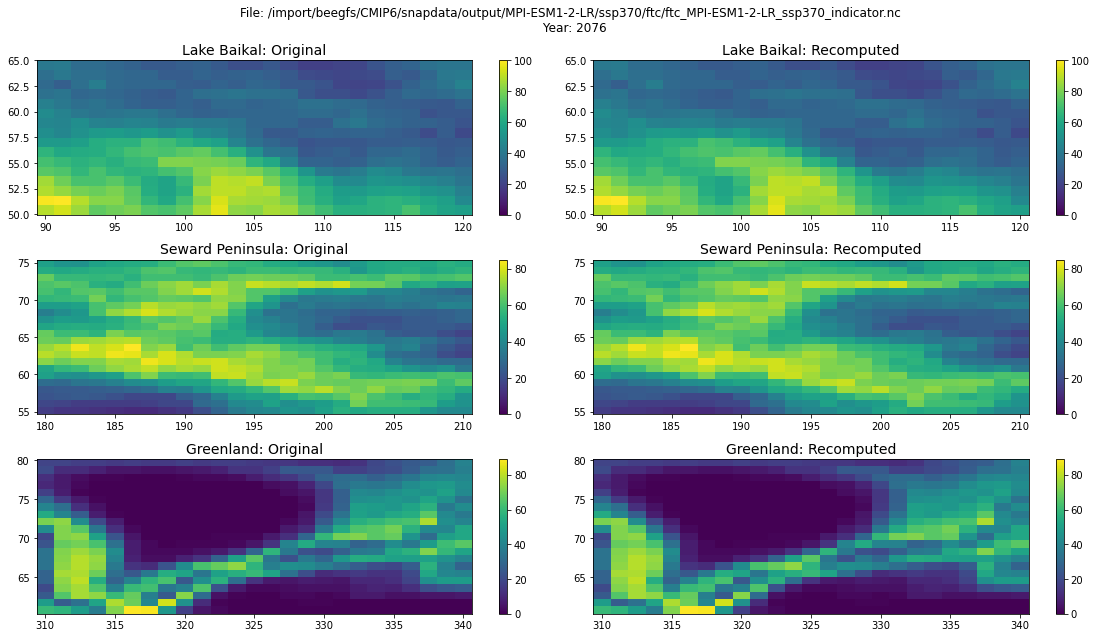

In [267]:
# original_ds = xr.open_dataset(qc_files[0])
# recomputed_ds = find_inputs_and_recompute_indicator(qc_files[0], input_dir)
# if are_they_equal(qc_files[0], original_ds, recomputed_ds):
#     slice_and_plot(qc_files[0], original_ds, recomputed_ds)


In [268]:
for f in qc_files:
    recomputed_ds = find_inputs_and_recompute_indicator(f, input_dir)
    original_ds = xr.open_dataset(f)
    if are_they_equal(f, original_ds, recomputed_ds):
        slice_and_plot(f, original_ds, recomputed_ds)